# Case study of uniaxial tensile tests

This is an example of how to use Paramaterial to process a dataset of uniaxial tensile test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

## Modelling
- Make representative curves
- Fit models
- Fit equations for model parameters

In [1]:
from typing import Callable

import numpy as np
from matplotlib import pyplot as plt

import paramaterial as pam
from paramaterial import ModelSet
from paramaterial.models import ramberg
from paramaterial.plug import DataSet, DataItem

Start with processed data.

In [2]:
processed_ds = DataSet('data/02 processed data', 'info/02 processed info.xlsx')

Setup plotting.

In [3]:
styler = pam.plotting.Styler(
    color_by='temperature', cmap='plasma', color_by_label='(°C)', color_norm=plt.Normalize(20, 320),
    plot_kwargs=dict(grid=True))
styler.style_to(processed_ds.sort_by(['temperature', 'lot']))


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


subplot_cfg = dict(
    shape=(3, 3), sharex='all', sharey='all', hspace=0.2,
    rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
    cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
    plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI']
)


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(ds=ds, styler=styler, plot_legend=False, **subplot_cfg, **kwargs)


def subplot_wrapper(ds: DataSet, plot_func: Callable[[DataItem], DataItem], **plot_func_kwargs):
    return pam.plotting.subplot_wrapper(ds=ds, plot_func=plot_func, **subplot_cfg, **plot_func_kwargs)


stress_strain_labels = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')

In [ ]:
def trim_for_fitting(di):
    di.data = di.data[di.data['interp_Strain'] <= 0.01]
    return di


fit_ds = DataSet('data/02 processed data', 'info/02 processed info.xlsx').apply(trim_for_fitting)
ms = ModelSet(ramberg, ['E', 's_y', 'C', 'n'], [(35e3, 90e3), (1., 280.), (30, 220.), (0.01, 0.8)], scipy_func='basinhopping')
ms.fit(temp_repr_ds, 'interp_Strain', 'mean_Stress_MPa', sample_size=40)
temp_ramberg_ds = ms.predict()

### Make representative curves
There is clear temperature dependence.
We are also interested in differences between lots.
We therefore make representative curves:
- Grouped by temperature
- Grouped by temperature and lot

Make representative curves grouped by temperature.

In [4]:
# pam.processing.make_representative_data(ds=processed_ds,
#                                         data_dir='data/03 temp repr data', info_path='info/03 temp repr info.xlsx',
#                                         repr_col='Stress_MPa', repr_by_cols=['temperature'],
#                                         interp_by='Strain', interp_end='min_of_maxes', interp_res=1000)
temp_repr_ds = DataSet('data/03 temp repr data', 'info/03 temp repr info.xlsx', test_id_key='repr id')
temp_repr_ds

|---
DataSet with 6 DataItems.
	Columns in info:
		repr id, temperature, nr averaged
	Columns in data:
		interp_Strain, mean_Stress_MPa, std_Stress_MPa, up_std_Stress_MPa, down_std_Stress_MPa, up_2std_Stress_MPa, down_2std_Stress_MPa, up_3std_Stress_MPa, down_3std_Stress_MPa, min_Stress_MPa, max_Stress_MPa, q1_Stress_MPa, q3_Stress_MPa
---|

Plot representative curves grouped by temperature.

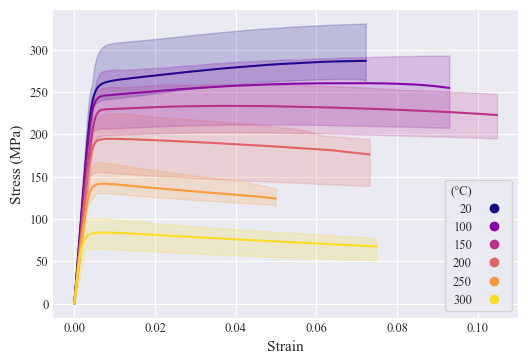

In [5]:
repr_stress_strain_labels = dict(x='interp_Strain', y='mean_Stress_MPa',
                                 fill_between=('min_Stress_MPa', 'max_Stress_MPa'),
                                 xlabel='Strain', ylabel='Stress (MPa)')  # todo: make error bar plots
ds_plot(temp_repr_ds, **repr_stress_strain_labels);

Make representative curves grouped by temperature and lot.

In [6]:
# pam.processing.make_representative_data(ds=processed_ds,
#                                         data_dir='data/03 temp lot repr data',
#                                         info_path='info/03 temp lot repr info.xlsx',
#                                         repr_col='Stress_MPa', repr_by_cols=['temperature', 'lot'],
#                                         interp_by='Strain', interp_end='min_of_maxes', interp_res=1000)
temp_lot_repr_ds = DataSet('data/03 temp lot repr data', 'info/03 temp lot repr info.xlsx', 'repr id')
temp_lot_repr_ds

|---
DataSet with 52 DataItems.
	Columns in info:
		repr id, temperature, lot, nr averaged
	Columns in data:
		interp_Strain, mean_Stress_MPa, std_Stress_MPa, up_std_Stress_MPa, down_std_Stress_MPa, up_2std_Stress_MPa, down_2std_Stress_MPa, up_3std_Stress_MPa, down_3std_Stress_MPa, min_Stress_MPa, max_Stress_MPa, q1_Stress_MPa, q3_Stress_MPa
---|

Plot representative curves grouped by temperature and lot.

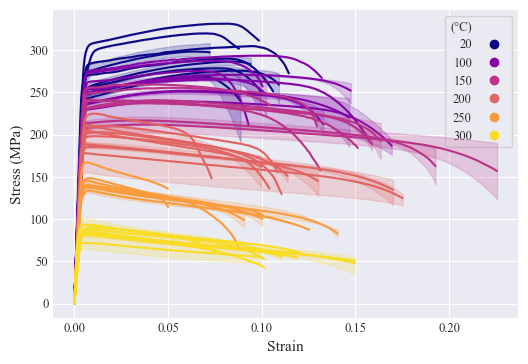

In [7]:
ds_plot(temp_lot_repr_ds, **repr_stress_strain_labels);

### Fit models
- Trim to 0.01 Strain
- Fit models to temperature grouped curves
- Fit models to temperature and lot grouped curves

In [8]:
def trim_for_fitting(di):
    di.data = di.data[di.data['interp_Strain'] <= 0.01]
    return di


temp_repr_ds = temp_repr_ds.apply(trim_for_fitting)
temp_lot_repr_ds = temp_lot_repr_ds.apply(trim_for_fitting)
# ds_plot(temp_repr_ds, **repr_stress_strain_labels);
# ds_subplots(temp_lot_repr_ds, **repr_stress_strain_labels);

### Fit models to small-strain representative data

In [16]:
ms = ModelSet(ramberg, ['E', 's_y', 'C', 'n'], [(35e3, 90e3), (1., 280.), (30, 220.), (0.01, 0.8)], scipy_func='basinhopping')
ms.fit(temp_repr_ds, 'interp_Strain', 'mean_Stress_MPa', sample_size=40)
temp_ramberg_ds = ms.predict()
# ms.fit(temp_lot_repr_ds, 'interp_Strain', 'mean_Stress_MPa', sample_size=50)
# temp_lot_ramberg_ds = ms.predict()
# temp_lot_ramberg_ds

In [17]:
print(temp_ramberg_ds.info_table)
ms.params_table

        repr id temperature nr averaged
0  repr_id_0001          20          19
1  repr_id_0002         100          19
2  repr_id_0003         150          12
3  repr_id_0004         200          19
4  repr_id_0005         250          12
5  repr_id_0006         300          19


,model id,E,s_y,C,n
0,model_repr_id_0001,58489.731344,113.303493,220.000000,0.069426
0,model_repr_id_0002,57013.199021,81.370023,220.000000,0.051232
0,model_repr_id_0003,47841.325238,54.474618,220.000000,0.039588
0,model_repr_id_0004,47002.637152,14.743813,220.000000,0.035854
0,model_repr_id_0005,39089.583348,1.000000,166.940700,0.030921
0,model_repr_id_0006,40413.524568,1.000000,107.315527,0.048604


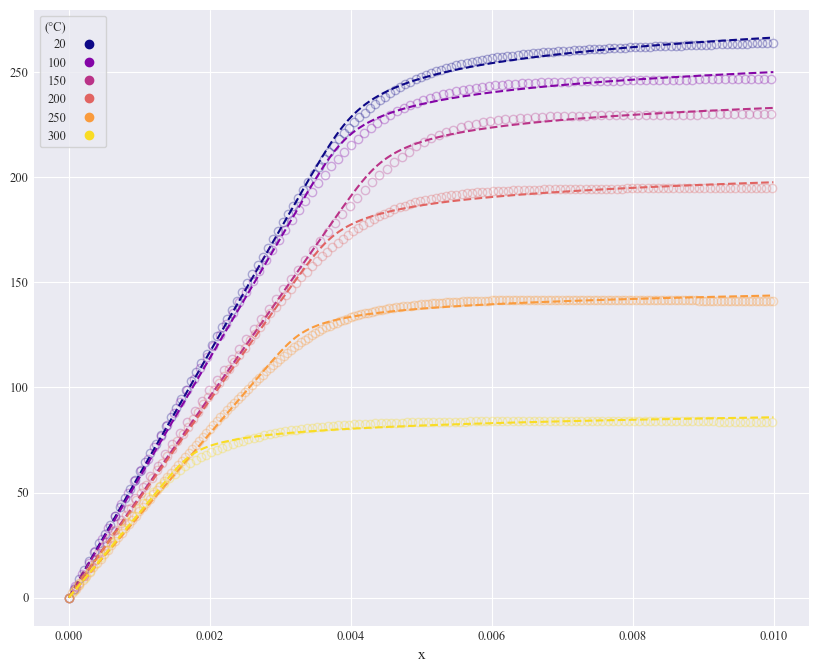

In [18]:
ax = ds_plot(temp_repr_ds, x='interp_Strain', y='mean_Stress_MPa', alpha=0.3, lw=0, marker='o', mfc='none',figsize=(10,8))
ds_plot(temp_ramberg_ds, x='x', y='y', ls='--', ax=ax);
# ds_subplots(temp_lot_ramberg_ds, x='x', y='y');